<a href="https://colab.research.google.com/github/james-lucius/qureca_ADEQUATE/blob/main/M9_66_QNNs_6_6_Example_Replication_of_a_Quantum_State.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://gitlab.com/qworld/qeducation/educational-materials/adequate-qbook1/raw/main/qworld/images/adq_1.png" align="left" width=450>

_prepared by Claudia Zendejas-Morales_

## 6.6 Example: Replication of a Quantum State

Let's look at a complete example using [PennyLane](https://pennylane.ai/).

Our QGAN will replicate the state of a one-qubit, characterized by three angles; the generator will not have direct access to that quantum state.

The dataset will consist of multiple copies of a one-qubit state, with the objective of training the generator to be able to prepare the same state (or one very close to it). What we'll be doing is very similar to [quantum state tomography](https://en.wikipedia.org/wiki/Quantum_tomography), which applies quantum operations and measurements to multiple copies of a state and reconstructs the original state from the results.

On this occasion we will rely on [PyTorch](https://pytorch.org/) to train our QGAN.

Setting up the environment:

In [ ]:
!pip install pennylane==0.40.0 &> /dev/null   # use "&> /dev/null" so that the standard output of the installation is not displayed

print("Setup completed")

Setup completed


Let's begin with some necessary imports and setting some seeds to make sure that our results are reproducible:

In [ ]:
import pennylane as qml
import numpy as np

import torch
import torch.nn as nn

seed = 1234
np.random.seed(seed)
torch.manual_seed(seed)

Let's construct the state $|\psi_1\rangle$ using the quantum gate $U3\left(\theta,\phi,\delta\right)$, which allows us to create any one-qubit state; we will fix the values of the angles.

In [ ]:
theta = np.pi / 4
phi = np.pi / 3
delta = np.pi / 5


def PrepareTrueState():
  qml.U3(theta, phi, delta, wires=0)

Now, let's define the **Generator**, which will receive its own parameters or weights to be tuned; we'll use the same $U3$ gate since its fitting will only be for the state of a single qubit.

In [ ]:
def Generator(weights):
    qml.U3(weights[0], weights[1], weights[2], wires=0)

To define the **Discriminator**, we will first create a **variational form**, which will be a variation of *two-local*. It also receives its own parameters or weights that will be sought to be fitted.

In [ ]:
def disc_var_form(nqubits, weights, reps=1):

  par = 0                                     # index for parameters

  for rep in range(reps):                     # repeat 'reps' times

    for q in range(nqubits):
      qml.RX(weights[par], wires=q)
      par += 1
      qml.RY(weights[par], wires=q)
      par += 1
      qml.RZ(weights[par], wires=q)
      par += 1
    for i in range(nqubits - 1):
      qml.CNOT(wires=[i, i + 1])

  for q in range(nqubits):
    qml.RX(weights[par], wires=q)
    par += 1
    qml.RY(weights[par], wires=q)
    par += 1
    qml.RZ(weights[par], wires=q)
    par += 1

Let's visualize the variational form for the case of `2` qubits and `2` repetitions:

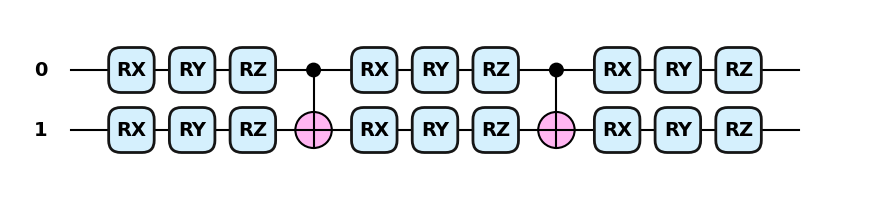

In [ ]:
fig, ax = qml.draw_mpl(disc_var_form, style='pennylane')(2, np.random.rand(18), 2)
fig.set_size_inches(8.5, 1.8)
fig.show()

Now let's create the Discriminator using the previous variational form, to which we will indicate `2` qubits and `3` repetitions:

In [ ]:
def Discriminator(weights):
  disc_var_form(2, weights, reps=3)

For the classifier, we will need a measurement operation for which we will take the expectation value of $M=|0\rangle\langle 0|$ in the first qubit. Remember that this operator has associated eigenvalues of $1$ and $0$, which will help the Discriminator to interpret the state as "real" or "fake," respectively.

In [ ]:
state0 = [[1], [0]]               # define state |0>

M = state0 * np.conj(state0).T    # create matrix M = |0><0|

Now, we'll define two quantum nodes. The first will connect the generation of the true state $|\psi_1\rangle$ with the Discriminator. The second will connect the Generator with the Discriminator. This way, we can use the results from both nodes to calculate the loss.

In [ ]:
dev = qml.device('default.qubit', wires=2)


@qml.qnode(dev, interface="torch", diff_method="backprop")
def true_discriminator(weights_dis):                            # QNode with the true state and the Discriminator

  PrepareTrueState()
  Discriminator(weights_dis)

  return qml.expval(qml.Hermitian(M, wires=[0]))                # return the expectation value of M in the first qubit


@qml.qnode(dev, interface="torch", diff_method="backprop")
def generator_discriminator(weights_gen, weights_dis):          # QNode with the Generator and the Discriminator

  Generator(weights_gen)
  Discriminator(weights_dis)

  return qml.expval(qml.Hermitian(M, wires=[0]))                # return the expectation value of M in the first qubit

Note that since the Discriminator works with both qubits of our QGAN, we could have also used the expectation value of $M$ in the second qubit.

$$$$

Our Discriminator needs to classify two data points: the true state $|\psi_1\rangle$ with a label of $1$ and the generated state $|\psi_g\rangle$ with a label of $0$. Recalling the binary cross-entropy loss function reviewed in section 6.3.1, we will then calculate:

$$
L_D \;=\; -\tfrac12 \Bigl(\log \bigl[D(\lvert \psi_1\rangle)\bigr] \;+\; \log \bigl[1 - D(\lvert \psi_g\rangle)\bigr]\Bigr)
$$

In [ ]:
def discriminator_loss(weights_gen, weights_dis):

  out_true = true_discriminator(weights_dis)                      # outcome of the discriminator with the true state

  out_gen = generator_discriminator(weights_gen, weights_dis)     # outcome of the discriminator with a generated state

  return -(torch.log(out_true) + torch.log(1 - out_gen))/2        # binary cross-entropy loss function value

Our Generator aims to fool the Discriminator. In Section 6.3.1, we also defined a reasonable loss function for the Generator:

$$
L_G \;=\; - \log \bigl[D(\lvert \psi_g\rangle)\bigr]
$$

In [ ]:
def generator_loss(weights_gen, weights_dis):

  out_gen = generator_discriminator(weights_gen, weights_dis)     # outcome of the discriminator with a generated state

  return -torch.log(out_gen)                                      # binary cross-entropy loss function value when tasked to classify the true state

Let's prepare what is necessary for the training process:

In [ ]:
weights_gen = torch.rand(3, requires_grad=True)                 # initialization of the weights for the Generator
                                                                # 3 weights are needed because there are 3 angles to fit
                                                                # requires_grad indicates that PyTorch will be able to calculate gradients for these parameters

weights_dis = torch.rand((3 + 1) * 2 * 3, requires_grad=True)   # initialization of the weights for the Discriminator
                                                                # 3+1 groups of parameterized gates with 3 parameters are needed in each of the 2 qubits



opt_gen = torch.optim.SGD([weights_gen], lr=0.5)                # optimizer for the Generator, use Stochastic Gradient Descent

opt_dis = torch.optim.SGD([weights_dis], lr=0.5)                # optimizer for the Discriminator, use Stochastic Gradient Descent

Let's run the training process:

In [ ]:
dis_losses = []                                                   # Discriminator losses history
gen_losses = []                                                   # Generator losses history
log_weights = []                                                  # Generator weights history

epochs = 150                                                      # number of epochs

for i in range(epochs):
                                                                  # train the Discriminator
  opt_dis.zero_grad()                                             # reset the Discriminator optimizer
  lossd = discriminator_loss(weights_gen.detach(), weights_dis)   # calculate the Discriminator loss
                                                                  #   use 'detach' to remove the need to compute gradients for the Generator weights
                                                                  #   because the Discriminator optimizer won't touch them
  lossd.backward()                                                # backpropagate the Discriminator loss (calculate the gradients of the calculated loss)
  opt_dis.step()                                                  # update the Discriminator weights (run a step of the Discriminator optimizer)

                                                                  # train the Generator
  opt_gen.zero_grad()                                             # reset the Generator optimizer
  lossg = generator_loss(weights_gen, weights_dis.detach())       # calculate the Generator loss
                                                                  #   use 'detach' to remove the need to compute gradients for the Discriminator weights
                                                                  #   because the Generator optimizer won't touch them
  lossg.backward()                                                # backpropagate the Generator loss (calculate the gradients of the calculated loss)
  opt_gen.step()                                                  # update the Generator weights (run a step of the Generator optimizer)

  lossd = float(lossd)                                            # store the histopry of losses and weights
  lossg = float(lossg)
  dis_losses.append(lossd)
  gen_losses.append(lossg)
  log_weights.append(weights_gen.detach().clone().numpy())        # use 'clone' to store a copy of the weights at that iteration and not a reference to the weights tensor

  if (np.mod((i+1), 15) == 0):                                    # print the losses every 15 epochs
    print("Epoch", i+1, end= " ")
    print("| Discriminator loss:", round(lossd, 4), end=" ")
    print("| Generator loss:", round(lossg, 4))

Epoch 15 | Discriminator loss: 0.6701 | Generator loss: 0.7065
Epoch 30 | Discriminator loss: 0.6987 | Generator loss: 0.6791
Epoch 45 | Discriminator loss: 0.6931 | Generator loss: 0.6992
Epoch 60 | Discriminator loss: 0.6931 | Generator loss: 0.6924
Epoch 75 | Discriminator loss: 0.6932 | Generator loss: 0.6927
Epoch 90 | Discriminator loss: 0.6931 | Generator loss: 0.6934
Epoch 105 | Discriminator loss: 0.6931 | Generator loss: 0.6931
Epoch 120 | Discriminator loss: 0.6931 | Generator loss: 0.6931
Epoch 135 | Discriminator loss: 0.6931 | Generator loss: 0.6932
Epoch 150 | Discriminator loss: 0.6931 | Generator loss: 0.6931


We observe that both the Discriminator and Generator losses are close to $-\log\tfrac12$, which means there's a good chance the training was successful, as mentioned in section 6.1.1.

Let's use the historical data to plot the evolution of the training process:

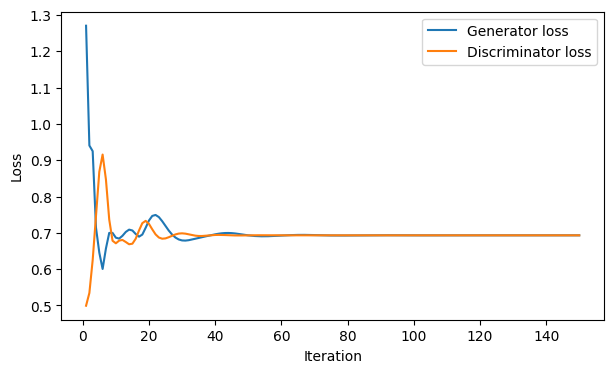

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 4))
epochs = np.array(range(len(gen_losses))) + 1
plt.plot(epochs, gen_losses, label = "Generator loss")
plt.plot(epochs, dis_losses, label = "Discriminator loss")
plt.ylabel("Loss")
plt.xlabel("Iteration")
plt.legend()
plt.show()

Let's see if our QGAN learned what we wanted it to do. Our training will be successful if the state returned by the Generator is close to the true state $|\psi_1\rangle$.

We are going to measure the expectation values of the three Pauli matrices $X$, $Y$ and $Z$, which will tell us the state of a qubit with respect to its Bloch sphere coordinates, respectively.

To find these expectation values, we will create two quantum nodes that will return these measurements; one for the true state $|\psi_1\rangle$ and the other for the state returned by the trained Generator.

In [ ]:
@qml.qnode(dev, interface="torch")
def generated_coordinates(weights_gen):

  Generator(weights_gen)                    # get the state given by the Generator with the trained weights
  return [qml.expval(qml.PauliX(0)),        # return the Bloch sphere coordinates
          qml.expval(qml.PauliY(0)),
          qml.expval(qml.PauliZ(0))]



@qml.qnode(dev, interface="torch")
def true_coordinates():

  PrepareTrueState()                        # get the true state
  return [qml.expval(qml.PauliX(0)),        # return the Bloch sphere coordinates
          qml.expval(qml.PauliY(0)),
          qml.expval(qml.PauliZ(0))]


psi_g = generated_coordinates(weights_gen)
psi_1 = true_coordinates()
print("Bloch coordinates")
print(f"-Generated:\t{psi_g[0]:.6f}\t{psi_g[1]:.6f}\t{psi_g[2]:.6f}")
print(f"-True:     \t{psi_1[0]:.6f}\t{psi_1[1]:.6f}\t{psi_1[2]:.6f}")

Bloch coordinates
-Generated:	0.353542	0.612376	0.707109
-True:     	0.353553	0.612372	0.707107


The coordinate values of both states are really close, we can say that the QGAN did its job successfully.

Let's review how the state provided by the Generator evolved during training. Let's show the plots comparing the states (true and generated) in different training iterations.

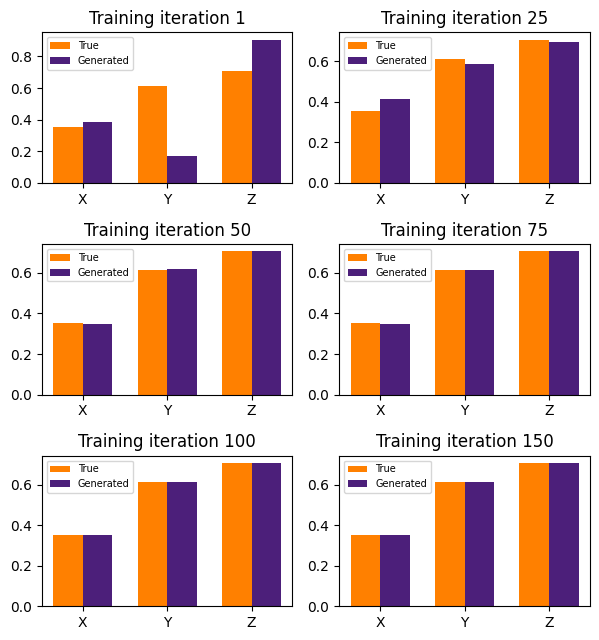

In [ ]:
true_coords = true_coordinates()                                            # get the coordinates of the true state once


def plot_coordinates(ax, iteration):

  generated_coords = generated_coordinates(log_weights[iteration - 1])      # get the coordinates of the generated state for the indicated iteration

  labels = ["X", "Y", "Z"]
  x = np.arange(len(labels))
  width = 0.35

  ax.bar(x - width/2, true_coords, width,                                   # plot the true coordinates
          color="#FF8000", label="True")
  ax.bar(x + width/2, generated_coords, width,                              # plot the generated coordinates
          color="#4C1F7A", label="Generated")

  ax.set_xticks(x)
  ax.set_xticklabels(labels)
  ax.set_title(f"Training iteration {iteration}")
  ax.legend(fontsize=7)




its = [1, 25, 50, 75, 100, 150]                                             # display information from these 6 iterations

fig, axes = plt.subplots(3, 2, figsize=(6.1, 6.5))                          # display all 6 plots at once

for i in range(6):

  row = i // 2                                                              # calculate position [row, col] for each plot
  col = i % 2

  plot_coordinates(axes[row, col], its[i])                                  # call plot_coordinates with the corresponding axis and the desired iteration


plt.tight_layout()                                                          # adjust spaces so that titles/legends do not overlap
plt.show()
